In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold


In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv', index_col = 'id')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv', index_col = 'id')
secondary = pd.read_csv('/kaggle/input/secondary-mushroom-dataset-data-set/MushroomDataset/secondary_data.csv', sep = ';')
tertiary = pd.read_csv('/kaggle/input/tertiary-mushroom-1-million-more-mushrooms/one_million_mushrooms.csv', sep = ';')

In [3]:
train_df = pd.concat([train_df, secondary, tertiary], ignore_index=True)

In [4]:
train_df

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4216009,p,7.03,f,d,e,t,d,c,y,5.83,...,NaN,NaN,e,NaN,NaN,f,f,NaN,d,u
4216010,e,4.92,x,NaN,w,f,x,c,n,7.02,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
4216011,p,8.68,x,d,e,t,d,c,w,8.98,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
4216012,p,8.08,f,d,e,t,d,c,w,6.32,...,NaN,NaN,e,NaN,NaN,f,f,NaN,d,a


In [5]:
features = train_df.drop('class', axis = 1).columns.tolist()

In [6]:
features_with_high_null_values = [feature for feature in features if (train_df[feature].isna().sum()/len(train_df) * 100) > 20]
features_with_high_null_values

['cap-surface',
 'gill-spacing',
 'stem-root',
 'stem-surface',
 'veil-type',
 'veil-color',
 'spore-print-color']

In [7]:
categorical_features = train_df[features].select_dtypes(include = 'object').columns.tolist()
numerical_features = list(set(features) - set(categorical_features))

In [8]:
def cleaner(df, cols_to_filter):

    # ? NO DIFFERENCE IN STRATEGY

    # for col in categorical_features:
    #     df.loc[df[col].value_counts(dropna = False)[df[col]].values < 100, col] = np.nan
    #     df[col] = df[col].fillna('missing')
    #     df[col] = df[col].astype('category')
    features_dict = {
        'cap_shape': ['x', 'f', 's', 'b', 'o', 'p', 'c'],
        'cap_surface': ['t', 's', 'y', 'h', 'g', 'd', 'k', 'e', 'i', 'w', 'l'],
        'cap_color': ['n', 'y', 'w', 'g', 'e', 'o', 'p', 'r', 'u', 'b', 'k', 'l'],
        'does_bruise_or_bleed': ['f', 't'],
        'gill_attachment': ['a', 'd', 'x', 'e', 's', 'p', 'f'],
        'gill_spacing': ['c', 'd', 'f'],
        'gill_color': ['w', 'n', 'y', 'p', 'g', 'o', 'k', 'f', 'r', 'e', 'b', 'u'],
        'stem_root': ['b', 's', 'r', 'c', 'f'],
        'stem_surface': ['s', 'y', 'i', 't', 'g', 'k', 'h', 'f'],
        'stem_color': ['w', 'n', 'y', 'g', 'o', 'e', 'u', 'p', 'k', 'r', 'l', 'b', 'f'],
        'veil_type': ['u'],
        'veil_color': ['w', 'y', 'n', 'u', 'k', 'e'],
        'has_ring': ['f', 't'],
        'ring_type': ['f', 'e', 'z', 'l', 'r', 'p', 'g', 'm'],
        'spore_print_color': ['k', 'p', 'w', 'n', 'r', 'u', 'g'],
        'habitat': ['d', 'g', 'l', 'm', 'h', 'w', 'p', 'u'],
        'season': ['a', 'u', 'w', 's']
    }
    
    for classes, cols  in zip(features_dict.keys(), cols_to_filter):
        # df.loc[(~df[cols].isin(features_dict[classes])) & pd.notna(df[cols]), cols] = 'missing'
        df.loc[~df[cols].isin(features_dict[classes]), cols] = "missing"
        df[cols] = df[cols].astype('category')

    return df

In [9]:
def feature_engineering(df):
    df['stem-area'] = df['stem-height'] * df['stem-width']
    return df

In [10]:
train_df = cleaner(train_df, categorical_features)
test_df = cleaner(test_df, categorical_features)

In [11]:
# train_df = feature_engineering(train_df)
# test_df = feature_engineering(test_df)

In [12]:
knn_imputer = KNNImputer(n_neighbors = 3) # KNN imputer uses other numerical features to find values for the missing values

train_df['cap-diameter'] = knn_imputer.fit_transform(train_df[['cap-diameter']]) 
test_df['cap-diameter'] = knn_imputer.fit_transform(test_df[['cap-diameter']])

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4216014 entries, 0 to 4216013
Data columns (total 21 columns):
 #   Column                Dtype   
---  ------                -----   
 0   class                 object  
 1   cap-diameter          float64 
 2   cap-shape             category
 3   cap-surface           category
 4   cap-color             category
 5   does-bruise-or-bleed  category
 6   gill-attachment       category
 7   gill-spacing          category
 8   gill-color            category
 9   stem-height           float64 
 10  stem-width            float64 
 11  stem-root             category
 12  stem-surface          category
 13  stem-color            category
 14  veil-type             category
 15  veil-color            category
 16  has-ring              category
 17  ring-type             category
 18  spore-print-color     category
 19  habitat               category
 20  season                category
dtypes: category(17), float64(3), object(1)
memory usage: 1

In [13]:
from sklearn.preprocessing import LabelEncoder

X = train_df.copy()
y = X.pop('class')

lab_enc = LabelEncoder().fit(y)
y = lab_enc.transform(y)

In [14]:


def model_report(estimator, X, y, cv = 5):
    print('='*80)
    print(f"     Model: {estimator.__class__.__name__}")
    print('='*80)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 1/cv, shuffle = True, stratify = y, random_state = 42)

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score : {mcc.mean():.6f}")

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title('Confusion Matrix')
    plt.show()

    print()


In [15]:
def model_trainer(model, X, y, n_splits = 5, random_state = 42):
    skfold = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = random_state)
    oof_probs, oof_mccs = [], []
    print('='*80)
    print(f"Training {model.__class__.__name__}")
    print('='*80, end = '\n')

    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mcc = matthews_corrcoef(y_pred, y_test)
        oof_mccs.append(mcc)
        oof_probs.append(model.predict_proba(test_df))

        print(f"--- Fold {fold + 1} MCC Score: {mcc:.6f}")
        print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
    return oof_probs, oof_mccs

     Model: XGBClassifier
F1 Score : 0.994415
MCC Score : 0.987624


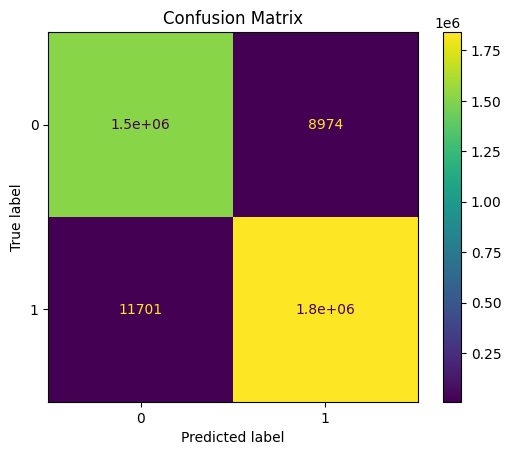

In [16]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(enable_categorical = True, device = 'cuda', tree_method = 'gpu_hist')

model_report(xgb_clf, X, y)

In [18]:
import optuna
from optuna.samplers import TPESampler

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.2, shuffle = True, stratify = y, random_state = 42) #  * train_size = 20%

In [20]:
def objective(trial):
    params = {

        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 500, 2500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
        "gamma": trial.suggest_float("gamma", 0, 1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 50),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        'max_cat_to_onehot': trial.suggest_int("max_cat_to_onehot", 4, 32),
        'max_cat_threshold': trial.suggest_int("max_cat_threshold", 32, 32),
        
        'device' : 'cuda',
        'tree_method' : 'gpu_hist',
        'enable_categorical' : True,
    }

    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    return matthews_corrcoef(y_test, y_pred)

study_name = 'xgb'
storage = 'sqlite:///xgb.db'

study = optuna.create_study(storage = storage,
                                study_name = study_name,
                                direction = "maximize",
                                sampler = TPESampler(),
                                load_if_exists=True)

study.optimize(objective, n_trials = 200)

print(study.best_params)

[I 2024-08-23 18:32:25,287] A new study created in RDB with name: xgb
[I 2024-08-23 18:35:45,701] Trial 0 finished with value: 0.9882945588836678 and parameters: {'max_depth': 23, 'learning_rate': 0.0071664868605651215, 'n_estimators': 2346, 'subsample': 0.7752426993441737, 'colsample_bytree': 0.7759894614708917, 'colsample_bylevel': 0.8865468852929594, 'colsample_bynode': 0.809864595173482, 'reg_alpha': 0.9413869201621846, 'reg_lambda': 0.09852528288949192, 'gamma': 0.6931660525581644, 'min_child_weight': 34, 'max_delta_step': 5, 'grow_policy': 'lossguide', 'max_cat_to_onehot': 6, 'max_cat_threshold': 32}. Best is trial 0 with value: 0.9882945588836678.
[I 2024-08-23 18:36:10,203] Trial 1 finished with value: 0.9878772868128285 and parameters: {'max_depth': 29, 'learning_rate': 0.0631691282553682, 'n_estimators': 2139, 'subsample': 0.9047324584431948, 'colsample_bytree': 0.7418809681605194, 'colsample_bylevel': 0.6556309433447378, 'colsample_bynode': 0.5109225685451148, 'reg_alpha': 0

{'max_depth': 20, 'learning_rate': 0.018963312033106996, 'n_estimators': 571, 'subsample': 0.9020486644448409, 'colsample_bytree': 0.45202814179550665, 'colsample_bylevel': 0.9990468297030884, 'colsample_bynode': 0.8836571541231754, 'reg_alpha': 0.4566484485414757, 'reg_lambda': 0.5892017866156632, 'gamma': 0.5305938568345651, 'min_child_weight': 1, 'max_delta_step': 1, 'grow_policy': 'lossguide', 'max_cat_to_onehot': 12, 'max_cat_threshold': 32}
